## Face Recognition

In [ ]:
import tensorflow
from google.colab import drive
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import cv2
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')
tensorflow.__version__

'2.4.1'

### Mount Drive and change working directory

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

### Extracting Zip files

In [ ]:
with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

### Function to load Images

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Defining a Funtion to load images


In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Checking a Sample Image 

In [ ]:
labels = np.array([meta.name for meta in metadata])

In [ ]:
print(len(metadata))

10770


- There are total of 10770 images enter a number within this range for the image to be shown

In [ ]:
print("Enter a number in range of 0 - 10770")

x = int(input())
img = load_image(metadata[x].image_path())

Enter a number in range of 0 - 10770
567


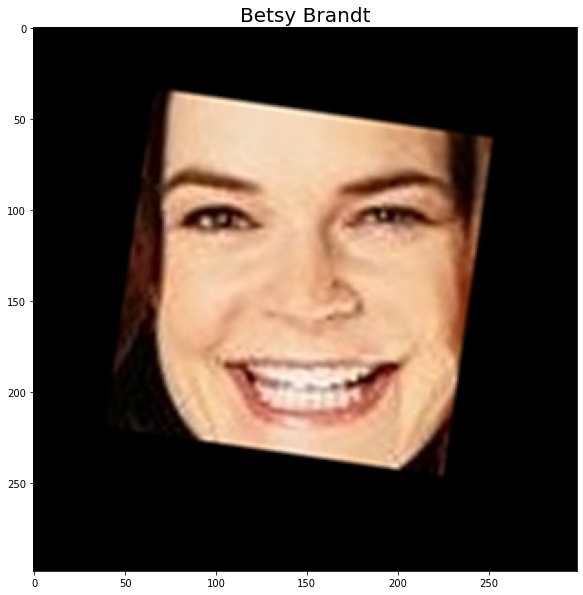

In [ ]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1)
title = labels[x].split('_')[1]

ax.set_title(title, fontsize = 20)
plt.imshow(img)

- lets see the meta data of the image

In [ ]:
print(img)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


### VGG Face Model

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### Load The model
- Lets see the summary of the model

In [ ]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### VGG_face_descriptor

In [ ]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate Embeddings for each images

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images

In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        image = load_image(m.image_path())
        image = cv2.resize(image, dsize = (224,224))
        image = (image / 255.).astype(np.float32)
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

### Calculate Distance between 2 images

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### Ploting The images and Getting the Distance for the same

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

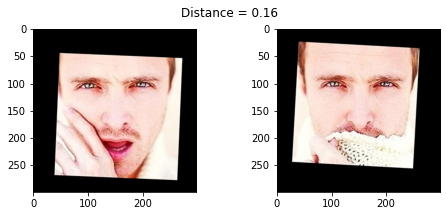

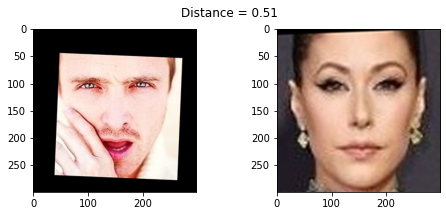

In [ ]:
show_pair(2, 3)
show_pair(2, 180)

- The distance is considerable more its more than .5

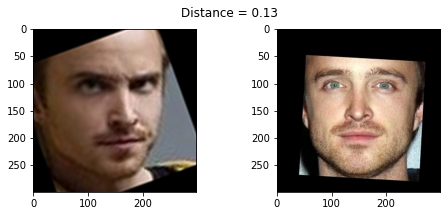

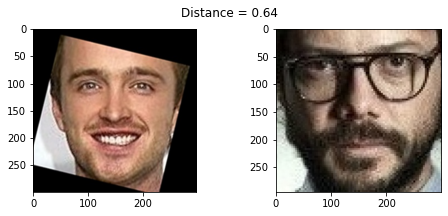

In [ ]:
show_pair(30, 31)
show_pair(20, 100)

- its very well notable in this pair its .64 from the original but the first image is less and its nearly accurate

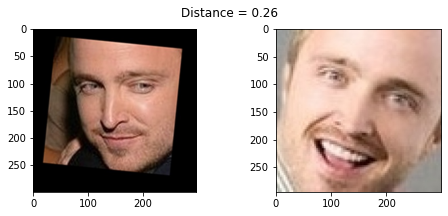

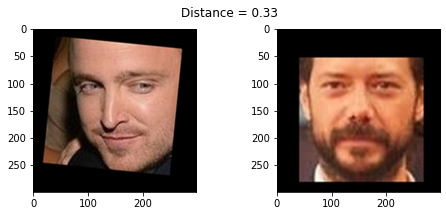

In [ ]:
show_pair(70, 72)
show_pair(70, 115)

- The distance in this pair is some what less in the second pair where its just .33

### Train and Test Set

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
# test labels
y_test = targets[test_idx]

In [ ]:
print("shape of the  X_train set : ", X_train.shape)
print("shape of the  X_test set : ", X_test.shape)
print("shape of the  y_train set : ", y_train.shape)
print("shape of the  y_test set : ", y_test.shape)

shape of the  X_train set :  (9573, 2622)
shape of the  X_test set :  (1197, 2622)
shape of the  y_train set :  (9573,)
shape of the  y_test set :  (1197,)


### Label Encoding

In [ ]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

### Standardise the Feature Values

In [ ]:
sc = StandardScaler()
X_SC_train = sc.fit_transform(X_train)
X_SC_test = sc.transform(X_test)

### Principle Component analysis - Dimentionality Reduction

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_SC_train.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58867122  18.986911    22.97710108 ...  99.99999983  99.99999999
 100.        ]


In [ ]:
res = list(filter(lambda i: i > 95, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {95}: {str(index)}')

Index of element just greater than 95: 347


In [ ]:
pca = PCA(n_components = index, random_state = 500, svd_solver = 'randomized', whiten = True)
pca.fit(X_SC_train)
X_pca_train = pca.transform(X_SC_train)
X_pca_test = pca.transform(X_SC_test)
display(X_pca_train.shape, X_pca_test.shape)

(9573, 347)

(1197, 347)

### Classifier

In [ ]:
clf = SVC(C= 1, kernel='rbf', random_state = 500, class_weight=None , gamma=0.001)
clf.fit(X_pca_train, y_train)
print('Train set Accuracy Score of the model : {0:.3f}'.format(clf.score(X_pca_train, y_train)))
print('Test set Accuracy Score of the model : {0:.3f}'.format(clf.score(X_pca_test, y_test)))


Train set Accuracy Score of the model : 0.994
Test set Accuracy Score of the model : 0.961


-  our model is giving us a good accuracy score in test and train set and it does not over fit

In [ ]:
y_pred = clf.predict(X_pca_test)
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      0.92      0.96        13
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      0.88      0.93         8
               Anna Gunn       0.82      1.00      0.90        14
           Anne Hathaway       0.93      0.93      0.93        14
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       0.81      1.00      0.90        13
    Benedict Cumberbatch       0.93      1.00      0.96        13
            Betsy Brandt       1.00      1.00      1.00         9
              Bill Gates       0.91      1.00      

- from above we can see the classification report
- here precision and recall for every image is shown

### Testing example

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = clf.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = enc.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

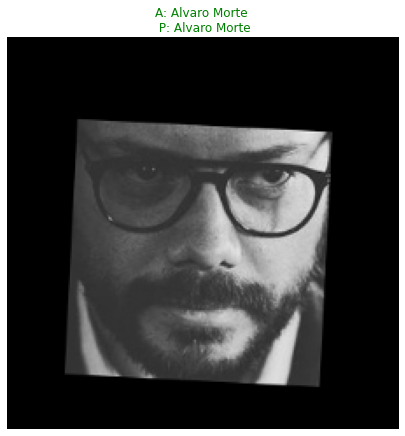

In [ ]:
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

- The prediction is accuracte
- lets check for few more images

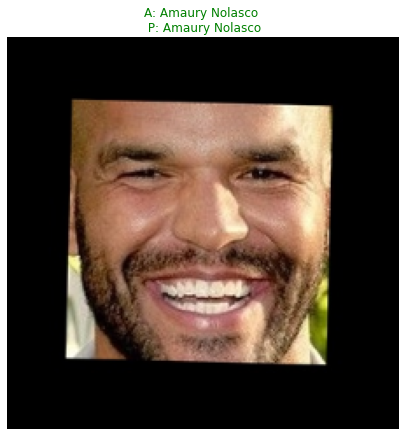

In [ ]:
sample_img, actual_name, pred_name = sample_img_plot(33)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

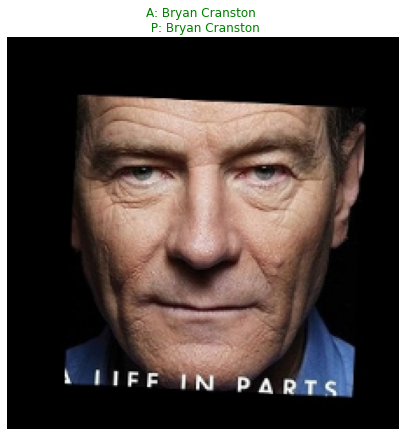

In [ ]:
sample_img, actual_name, pred_name = sample_img_plot(100)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

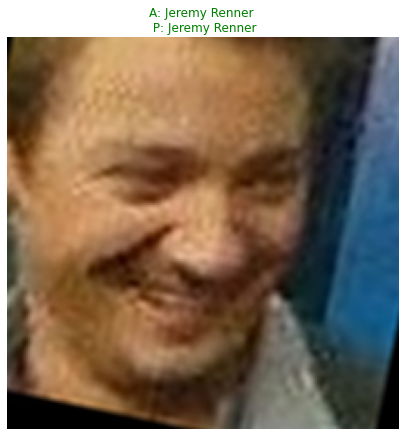

In [ ]:
sample_img, actual_name, pred_name = sample_img_plot(329)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

- so far our model is performing well and giving us accurate predictions on the above test images. the labels predicted and actual labels are accurate on the above images.
- 347 componants are used for 95% variance.
- the support vector classifier we built is giving 96 percent accuracy. which is a really good outcome.